In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

In [3]:
X_test = pd.read_csv("./soccer_binary_data/test/X_test",index_col=0)
Y_test = pd.read_csv("./soccer_binary_data/test/Y_test",index_col=0)
binary_catboost_probability = pd.read_csv('./result/catboost_binary_result',index_col=0)

In [4]:
X_test

,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,62.344111,0.040050,62.344111,0.040050,62.344111,0.040050,True,True,0.0,0.0
1,21,0,0,False,False,False,False,False,False,False,...,59.963744,0.041641,62.344111,0.040050,62.344111,0.040050,True,True,1.0,1.0
2,0,21,0,True,False,False,False,False,False,False,...,63.970052,0.229408,59.963744,0.041641,62.344111,0.040050,True,True,1.0,2.0
3,0,0,21,True,False,False,False,False,False,False,...,77.353726,0.247320,63.970052,0.229408,59.963744,0.041641,True,True,3.0,4.0
4,21,0,0,False,False,False,False,False,False,False,...,77.140580,0.245717,77.353726,0.247320,63.970052,0.229408,True,True,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79807,0,21,0,True,False,False,False,False,False,False,...,44.177657,0.549396,75.302099,0.417845,75.302099,0.417845,True,True,2.0,3.0
79808,8,0,21,False,False,False,False,False,False,False,...,67.452732,0.365382,71.166049,0.330111,47.354672,0.701388,False,False,2.0,4.0
79809,3,8,0,False,False,False,True,False,False,False,...,6.565622,0.105074,48.423868,0.520962,44.177657,0.549396,False,True,28.0,30.0
79810,21,3,8,False,False,False,False,False,False,False,...,98.061188,0.025458,98.472996,0.006993,67.452732,0.365382,False,True,4.0,32.0


In [5]:
binary_catboost_probability

,scores,concedes
0,0.002135,0.000691
1,0.004217,0.000980
2,0.002595,0.000955
3,0.001996,0.001415
4,0.001672,0.001311
...,...,...
79807,0.019984,0.001035
79808,0.000452,0.004370
79809,0.005203,0.006452
79810,0.002705,0.003359


#### 주어진 binary_catboost_probability예측값을 VAEP에 적용하기

- game_id = 3773689는 score와 concede가 둘 다 true인 데이터는 제거하고 학습했음
- 득점, 실점 예측확률값 - 기존 이벤트 데이터(위치, 행동 유형, 행동결과)를 매칭시킴(이때도 game_id=3,773,689는 제외)

In [6]:
# Configure file and folder names
datafolder = "./data-fifa/La Liga"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb_test_competitions.h5")
predictions_h5 = os.path.join(datafolder, "catboost_binary_predictions.h5")

In [7]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 35


In [8]:
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading game ids"):
    Ai = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

Loading game ids: 100%|██████████| 35/35 [00:00<00:00, 102.42it/s]


In [9]:
A

,game_id
0,3773457
1,3773457
2,3773457
3,3773457
4,3773457
...,...
82103,3773477
82104,3773477
82105,3773477
82106,3773477


In [10]:
binary_catboost_probability

,scores,concedes
0,0.002135,0.000691
1,0.004217,0.000980
2,0.002595,0.000955
3,0.001996,0.001415
4,0.001672,0.001311
...,...,...
79807,0.019984,0.001035
79808,0.000452,0.004370
79809,0.005203,0.006452
79810,0.002705,0.003359


In [11]:
# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, binary_catboost_probability], axis=1).groupby("game_id")
for k, df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[binary_catboost_probability.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 35/35 [00:00<00:00, 80.42it/s]


#### 득점-실점 확률, 득점확률변화량-실점확률변화량, VAEP값 계산

In [12]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    if game.game_id==3773689:
        continue
    
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
    
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 35/35 [00:01<00:00, 24.87it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [13]:
A

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_name,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,3764440,4771a598-13a9-4d13-8ea8-56cdd3d7579a,1,0.0,1042,12072.0,52.058824,33.655696,62.470588,42.435443,...,success,foot_left,Pere Milla Peña,Pere Milla,Elche,0.002149,0.000815,0.000000,-0.000000,0.000000
1,3764440,250b0afd-1449-499a-98ee-51f16d555da2,1,1.0,1042,24517.0,62.470588,42.435443,61.676471,43.382278,...,success,foot,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.002578,0.001179,0.000430,-0.000364,0.000066
2,3764440,68ec5c46-58b7-4c65-99a4-15db98b73772,1,1.0,1042,24517.0,61.676471,43.382278,76.411765,38.820253,...,success,foot_right,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.001982,0.001096,-0.000596,0.000083,-0.000514
3,3764440,2344b373-a95b-4430-ad19-4c1ea977c8f7,1,3.0,1042,24169.0,76.411765,38.820253,75.617647,38.131646,...,success,foot,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.002889,0.001259,0.000907,-0.000163,0.000744
4,3764440,c741ed1c-fa8a-4fe7-b5e0-8dd02da0d183,1,4.0,1042,24169.0,75.617647,38.131646,74.911765,14.891139,...,success,foot_right,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.002362,0.001256,-0.000526,0.000002,-0.000524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79807,3773695,4bb0d451-f9b5-44ad-928f-08ef9116d6ad,2,2931.0,217,5213.0,89.558824,39.422785,74.382353,51.731646,...,success,head,Gerard Piqué Bernabéu,Gerard Piqué,Barcelona,0.001969,0.006349,-0.002168,-0.004372,-0.006540
79808,3773695,42c1025b-18ea-47a2-8ab0-8670dbbdcc5f,2,2933.0,207,6583.0,74.382353,51.731646,87.088235,43.037975,...,fail,head,Carlos Soler Barragán,Carlos Soler,Valencia,0.004870,0.002850,-0.001479,-0.000882,-0.002361
79809,3773695,6064e5b5-3553-435e-93ce-b6e3cde88066,2,2935.0,217,5213.0,87.882353,42.263291,79.941176,54.141772,...,success,head,Gerard Piqué Bernabéu,Gerard Piqué,Barcelona,0.005407,0.002310,0.002556,0.002560,0.005117
79810,3773695,b41d85ef-a8da-4d00-ad66-ae11cab64323,2,2937.0,217,8118.0,79.941176,54.141772,79.764706,55.949367,...,success,foot,Frenkie de Jong,None,Barcelona,0.005799,0.001484,0.000392,0.000826,0.001218


### 아래 그림은 레알마드리드 vs 바르셀로나 경기에서 레알 마드리가 첫번째 골을 넣은 과정을 시각화한것이다.

- 일부코드는 해당 경기의 과정을 시각화하기위해 쿼리를 작성함(조건절을 빼고 작성시 다양한 용도로 활용가능)
- https://www.youtube.com/watch?v=EhodpjwTtag&t=1986s
- catboost로 예측한 VAEP는 마지막 슛팅을 수행한 벤제마에게 매우 높은 VAEP를 부여함
- 가장 좋은 성능을 보였던 boosting알고리즘의 한계 : 슛에만 높은 VAEP를 부여함(그 외에도 대부분 슛에만 높은 VAEP를 부여하는 경향이 있음)

2021-04-10 21:00:00 Real Madrid 2-1 Barcelona 12' dribble Lucas Vázquez Iglesias


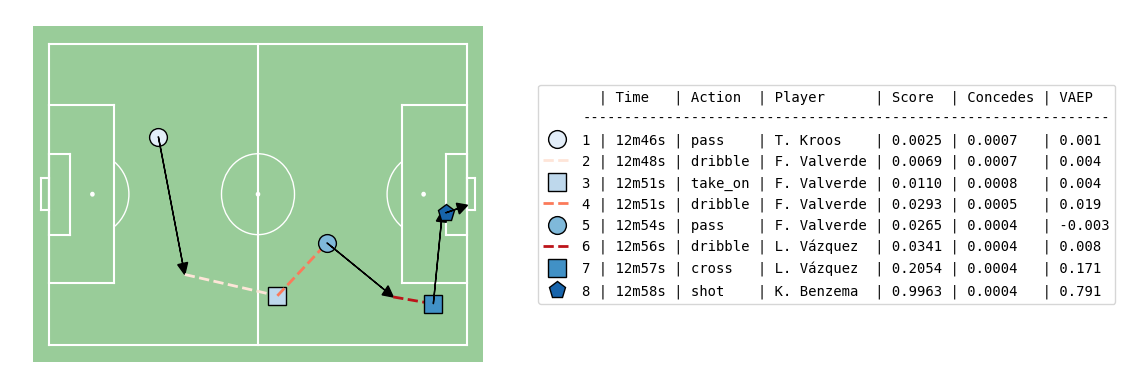

In [14]:
import matplotsoccer
import matplotlib.pyplot as plt
import matplotsoccer as mps
import matplotlib.pyplot as plt

sorted_A = A
# sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[(sorted_A.time_seconds>775.0) & (sorted_A.time_seconds<780.0)]
sorted_A = sorted_A[sorted_A.game_id==3773497]
sorted_A = sorted_A[sorted_A.team_name == "Real Madrid"] # view only actions from Belgium
#sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots
#sorted_A = sorted_A[(sorted_A['scores']<0.7) & (sorted_A['concedes']<0.7)]
def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 1):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 5 : i+3].copy()
    
    
    result = False
    for vaep, team in zip(a['vaep_value'],a['team_name']):
        if (team !="Real Madrid"):
            result = True

    if result:
        continue
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    a['type_name'] = a['type_name'].replace("_"," ")
    
    for index, name in zip(a.index,a['player_name']):
        name_lst = name.split()
        first_name = name_lst[0][0] + ". "
        last_name = name_lst[-1]

        a.loc[index,'player_name'] = first_name + last_name
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.4f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.4f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    #cols = ["time", "type_name", "player_name", "team_name", "result_name","scores", "concedes","offensive_value","defensive_value","vaep_value"]
    cols = ["time", "type_name", "player_name","scores", "concedes","vaep_value"]
    t = "시간"
    # if 33273 in a.index: 
    #     a.loc[33273,'start_x'] += 1.2
    #     a.loc[33273,'start_y'] += 1.6

    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle =  ["Time", "Action", "Player","Score", "Concedes","VAEP"],
                zoom=False,
                color="green")
   
    # for i,index in enumerate(a.index):
    #     text_name = f"({i+1}) {a.loc[index,'type_name']} \n {a.loc[index,'vaep_value']}"
    #     plt.text(a.loc[index,'start_x'],a.loc[index,'start_y'],text_name)